In [75]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import calendar as cal
import matplotlib.pyplot as plt
import altair as alt

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from matplotlib import style
style.use('ggplot')

[ 9  4  3  6  2 11 12  8  5 10  7 13  1]


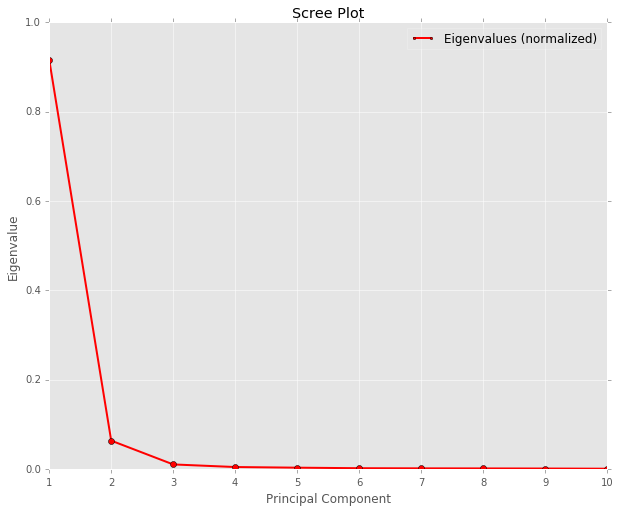

   X  Y  month  day  FFMC  ISI  temp  RH  wind  area
0  7  5      3    4  86.2  5.1   8.2  51   6.7   0.0
1  7  4     10    1  90.6  6.7  18.0  33   0.9   0.0
2  7  4     10    5  90.6  6.7  14.6  33   1.3   0.0
3  8  6      3    4  91.7  9.0   8.3  97   4.0   0.0
4  8  6      3    6  89.3  9.6  11.4  99   1.8   0.0
         P1        P2        P3  sum_of_sl
0 -0.002287  0.012841  0.003340   0.000181
1 -0.000860  0.005018 -0.003038   0.000035
2 -0.002054 -0.017481  0.130641   0.017377
3 -0.000741  0.010952  0.019812   0.000513
4 -0.003679 -0.118951  0.654716   0.442816
5 -0.000682 -0.051318  0.529173   0.282658
6 -0.009269 -0.203633  0.478679   0.270686
7  0.020852  0.969817  0.211096   0.985541
8 -0.000331  0.008986 -0.011791   0.000220
9 -0.999727  0.022580 -0.003090   0.999974


In [90]:
df = pd.read_csv('forest_fires.csv')
# dictionary used to translate month names to integer, 1 for january
month_to_num_dict = {key.lower(): value for value, key in enumerate(cal.month_abbr)}
# dictionary used to translate day names to integer, 0 for monday
day_to_num_dict = {key.lower(): value for value, key in enumerate(cal.day_abbr)}

grouped = df.groupby('month')
for group in grouped:
    df.replace(group[0], month_to_num_dict[group[0]], inplace=True)
    
grouped = df.groupby('day')
for group in grouped:
    df.replace(group[0], day_to_num_dict[group[0]], inplace=True)

clf = svm.SVR(kernel='linear')
# recursive feature elimination
sel = RFE(clf, n_features_to_select=1)
sel.fit(df, df['area'])
# display the feature ranking and selected features
print(sel.ranking_)

df.drop(['DMC', 'DC', 'rain'], 1, inplace=True)

pca = PCA()
pca.fit(df)
ei = pca.explained_variance_ratio_ # normalized eigen values
ei_vectors = pca.components_       # eigen vectors

ei_df = pd.DataFrame(ei, columns=['value'])
# ei_df['index'] = Series()
ei_df.to_csv('ei.csv')

fig = plt.figure(figsize=(10, 8))
pc = np.arange(len(ei)) + 1

plt.plot(pc, ei, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

graph = plt.legend(['Eigenvalues (normalized)'],
                   loc='best',
                   borderpad=0.3, 
                   shadow=False,
                   markerscale=0.4)

graph.get_frame().set_alpha(0.4)
graph.draggable(state=True)
plt.show()
pca = PCA(n_components=3)
pca.fit(df)
components = pd.DataFrame(pca.components_)
components = components.T.rename(columns={0: 'P1', 1: 'P2', 2: 'P3'})
print(df.head())
components = components.assign(sum_of_sl=
                               [sum([row[0] ** 2, row[1] ** 2, row[2] **2]) 
                                for row in components.values])
print(components)

In [91]:
print(df.head())

   X  Y  month  day  FFMC  ISI  temp  RH  wind  area
0  7  5      3    4  86.2  5.1   8.2  51   6.7   0.0
1  7  4     10    1  90.6  6.7  18.0  33   0.9   0.0
2  7  4     10    5  90.6  6.7  14.6  33   1.3   0.0
3  8  6      3    4  91.7  9.0   8.3  97   4.0   0.0
4  8  6      3    6  89.3  9.6  11.4  99   1.8   0.0


In [105]:
lgt_range = {'a': -7.20, 'b': -6.52}
lat_range = {'a': 41.74, 'b': 41.99}

lgt_interval = round((lgt_range['b'] - lgt_range['a']) / 9, 2)
lat_interval = round((lat_range['b'] - lat_range['a']) / 8, 2)
lgt_offset = round(lgt_interval / 2, 2)
lat_offset = round(lat_interval / 2, 2)

lat = {}
lgt = {}
for i in range(1, 10):
    lgt[i] = round((i - 1) * lgt_interval + lgt_range['a'] + lgt_offset, 2)
    lat[i] = round((i - 1) * lat_interval + lat_range['a'] + lat_offset, 2)
print(lgt)

{1: -7.16, 2: -7.08, 3: -7.0, 4: -6.92, 5: -6.84, 6: -6.76, 7: -6.68, 8: -6.6, 9: -6.52}


In [106]:
# function to replace values in a certain column
def group_and_replace(grouped_by, replacement, data, col=None):
    data[grouped_by] = [replacement[value] for value in data[grouped_by]]
    print(data.__class__)
    if col:
        data.columns = [col if name == grouped_by else name for name in data.columns.values]

# translate the x and y to longitude and latitude
# so that the csv can be converted into geojson
geo_df = df.copy()
group_and_replace('X', lgt, geo_df, 'longitude')
group_and_replace('Y', lat, geo_df, 'latitude')
print(geo_df.head())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
   longitude  latitude  month  day  FFMC  ISI  temp  RH  wind  area
0      -6.68     41.87      3    4  86.2  5.1   8.2  51   6.7   0.0
1      -6.68     41.84     10    1  90.6  6.7  18.0  33   0.9   0.0
2      -6.68     41.84     10    5  90.6  6.7  14.6  33   1.3   0.0
3      -6.60     41.90      3    4  91.7  9.0   8.3  97   4.0   0.0
4      -6.60     41.90      3    6  89.3  9.6  11.4  99   1.8   0.0


In [107]:
# try:
#     geo_df.to_csv('geo_fires.csv')
# except Exception as e:
#     print(e)